# This file is a continuation of the code from the numpy based hermite interpolation

## Original code comes from Nils Wandel, this is a reinterpretation

In [18]:
from matplotlib import pyplot as plt
import torch
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [47]:
# In this cell is the code which is used to compute coefficients for Hermite Kernels

def monomial_derivative(order, x, derivative = 0):
    """
    Returns the value of the derivative of a monomial at a point x.
    If the derivative = 0, returns the value of the monomial itself at x.
    """
    if derivative > order:
        return 0
    else:
        resulting_order = order - derivative
        return math.factorial(order) / math.factorial(resulting_order) * x** resulting_order

def get_monomial_values(highest_order, x, derivative):
    """
    Returns the values of the nth derivative of monomials of order i, where i is an integer ranging
    from 0 to highest_order (inclusive).
    
    Values are returned in a numpy array in order of increasing order.
    When derivative = 0, this corresponds to the values of the monomials themselves.
    """
    values = torch.zeros(highest_order + 1)
    for order in range(len(values)):
        values[order] = monomial_derivative(order, x, derivative)
    return values

def create_monomial_val_matrix(num_monomials, endpoints):
    
    if num_monomials % 2 != 0:
        raise Exception("num_monomials must be even as the functions are evaluated at two endpoints")
        
    # sort endpoints so that they are in order of increasing absolute value
    # this is needed since we compute coefficients to the right, and to the left, of 0.
    # wish to be able to reuse a single function
    endpoints.sort(key=abs)

    shape = (num_monomials, num_monomials)

    monomial_vals = torch.empty(shape, dtype=torch.float64)
    
    def populate_monomial_vals_matrix(support_point_index):
        num_derivative_evals = num_monomials // 2
        for i in range(num_derivative_evals):
            monomial_vals[i + support_point_index * num_derivative_evals,:] = get_monomial_values(num_monomials - 1, 
                                                                                                  endpoints[support_point_index], 
                                                                                                  i)

    
    populate_monomial_vals_matrix(support_point_index=0)
    populate_monomial_vals_matrix(support_point_index=1)
    
    return monomial_vals

def determine_coefficients(v, endpoints):
    '''
    v: a vector containing the values of the summed function and its derivatives at the support points.
        The first half of the vector contains the values and derivatives of the summed function at x = endpoints[0]
        The second half of the vector contains the values and derivatives of the summed function at x = endpoints[1]
        For instance, if len(v) == 4, then v = [f(endpoints[0]), f'(endpoints[0]), f(endpoints[1]), f'(endpoints[1])]
    endpoints: An array of length 2 containing the endpoint values (the domain of the function ranges from 0 
            to +-endpoint[1] usually)
    returns: a numpy array containing the coefficients of each monomial degree that is used to construct
            the polynomial satisfying the value and derivative constraints at support points.
            For instance, array([ 5.,  0.,  3., -2.]) corresponds to f(x) = 5 + 3x^2 - 2x^3
    '''
    MM = create_monomial_val_matrix(len(v), endpoints)
    return torch.linalg.solve(MM, v)

## Next, we show how we can compute hermite polynomials of nth order

In [88]:
def sign(x):
    s = torch.sign(x)
    s[s==0] = 1
    return s

def heaviside(x):
    return (torch.sign(x) + 1) / 2

def polynomial(weights, x):
    y = torch.zeros_like(x, dtype=torch.float64)
    for order in range(len(weights)):
        y += weights[order] * x ** order
    return y

def kernel(v, xvals):

    left_weights = determine_coefficients(v, [-1,0])
    right_weights = determine_coefficients(v, [0,1])
    
    left_polynomial = polynomial(left_weights, xvals)
    right_polynomial = polynomial(right_weights, xvals)
    
    return heaviside(-xvals) * left_polynomial + heaviside(xvals) * right_polynomial 

def kernels(highest_order, xvals):
    hermite_values = torch.eye(highest_order + 1, dtype=torch.float64)
    
    # for hermite, we only ever alter the value / derivative at x=0
    # all other derivatives and values are 0 (i.e. at 1 and -1)
    
    num_conditions = (highest_order + 1) // 2
    hermite_values = hermite_values[:num_conditions]

    yvals = torch.empty((num_conditions, xvals.shape[0]), dtype=torch.float64)
    for index, v in enumerate(hermite_values):
        y = kernel(v,xvals)
#         y /= torch.max(torch.abs(y)) # "normalize" curves to fit into [-1, 1]
        yvals[index,:] = y
    return yvals

In [89]:
xvals = torch.linspace(-1, 1, 100)
yvals = kernels(5, xvals)

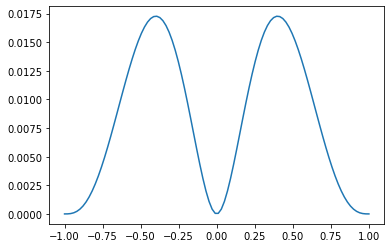

In [90]:
plt.plot(xvals, yvals[2])

## Now let's convolve some kernels!

In [91]:
def interpolate_wave(coefficients, kernels):
    '''
    Interpolates a wave function by convolving the coefficients with the hermite spline kernels
    coefficients: Tensor of size (minibatch, num_kernel_types, width)
    kernels: Tensor of size (num_kernel_types, output_waves (usually 1), width)
    '''
    stride = kernels.shape[2] // 2
    return F.conv_transpose1d(coefficients, kernels, 
         padding = 0, stride = stride, groups=1)

def generate_kernels(num_points, order):
    if num_points % 2 == 0:
        raise Exception("num_points must be odd!")
    xvals = torch.linspace(-1, 1, num_points, dtype=torch.float64, requires_grad=True)
    return xvals, kernels(order, xvals).unsqueeze(1) # array with shape (num_kernels, num_points). Also
                                              # insert new rank into tensor to correspond to convolution API

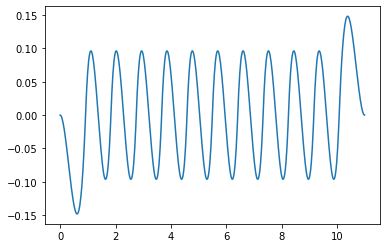

In [353]:
num_non_boundary_grid_points = 11

sample_coefficients = torch.ones(1,2, num_non_boundary_grid_points, dtype=torch.float64)
sample_coefficients[0,0,:] = 0

num_kernel_support_points = 101 # must be odd

xvals, sample_kernels = generate_kernels(num_kernel_support_points, 3)
wave = interpolate_wave(sample_coefficients, sample_kernels)

xvals2 = torch.linspace(0, num_non_boundary_grid_points, 1 + (num_non_boundary_grid_points + 1) * (num_kernel_support_points // 2))
plt.plot(xvals2, wave[0][0].detach())

## The cool thing is, we can even compute derivatives of this output function by multiplying the coefficients by the derivatives of our kernels

In [354]:
gradients = torch.empty(2,1,101, dtype=torch.float64)
for i in range(2):
    gradients[i,0,:] = torch.autograd.grad(torch.sum(sample_kernels[i]), 
                        inputs=xvals, 
                        retain_graph=True,
                        create_graph=True)[0]

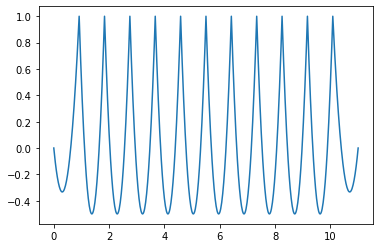

In [355]:
gradient_wave = interpolate_wave(sample_coefficients, gradients)

xvals2 = torch.linspace(0, num_non_boundary_grid_points, 1 + (num_non_boundary_grid_points + 1) * (num_kernel_support_points // 2))
plt.plot(xvals2, gradient_wave[0][0].detach())